# Introduction

*... a blindfolded monkey throwing darts at a newspaper's financial pages could select a portfolio that would do just as well as one carefully selected by experts...*

In the seminal 1973 publication, A Random Walk Down Wall Street, Burton Malkiel proposed that a portfolio chosen at random by a blindfolded monkey, by throwing darts at the financial section of a newspaper, could perform as well as one meticulously curated by financial experts. This is essentially a reformulation of the efficient market hypothesis i.e. in a security’s price series, all subsequent price changes are random departures from past prices

 To discern whether investment performance is a matter of skill or simply fortuity, one might undertake an empirical investigation akin to Malkiel's theoretical experiment with simian stock pickers. This could involve the creation of 'monkey' portfolios, each composed of a random assortment of stocks, weighted equally without regard to market capitalization.

 Should the analysis reveal that these arbitrarily constructed portfolios consistently yield superior returns compared to a capitalization-weighted index, before accounting for transaction expenses, it may imply that the element of chance plays a more significant role in investment success than traditionally acknowledged. This outcome would challenge the efficacy of skilful, strategic asset selection in favour of serendipity.

This experimental setup, akin to Monte Carlo analysis, aims to simulate the performance of randomly selected portfolios against a benchmark. The variables are the number of stocks in each index ($n$) and the rebalance frequency ($f$). The objective is to estimate the expected performance and standard deviation of these synthetic indices relative to the benchmark.

# Set up

### Install libraries

In [109]:
!pip install -q -U cvxpy

In [110]:
!pip install -q yfinance

In [111]:
!pip install -q qpsolvers[clarabel]

In [112]:
!pip install -q diffusers==0.20.2

In [113]:
!pip install -q cvxsimulator

In [114]:
import yfinance as yf
import pandas as pd
import numpy as np

In [115]:
import seaborn as sns
from scipy.stats import norm, norminvgauss
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [116]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from typing import Any

In [117]:
from cvx.simulator import Builder
pd.options.plotting.backend = "plotly"
import cvxpy as cp
from cvx.simulator import utils

from scipy.linalg import sqrtm

### Utils

In [ ]:
def drop_incomplete_prices(dataframe):
    """
    Drops columns (stocks) with any NaN values (gaps in prices).
    """
    # Drop columns with any NaN values
    return dataframe.dropna(axis=1)

In [148]:
def calculate_expected_shortfall(daily_returns_df, confidence_level=0.95):
    """
    Calculate the Expected Shortfall (CVaR) for the given daily returns at the specified confidence level.
    """
    # Calculate the weighted daily returns assuming equal weights for simplicity
    weights = np.ones(len(daily_returns_df.columns)) / len(daily_returns_df.columns)
    weighted_daily_returns = (daily_returns_df * weights).sum(axis=1)

    # Sort the daily returns to find the cutoff for the worst cases
    sorted_returns = np.sort(weighted_daily_returns)

    # Find the percentile index
    percentile_index = max(int(confidence_level * len(sorted_returns)), 1)
    cutoff = sorted_returns[percentile_index - 1]

    # Calculate the average of the returns that are worse than the cutoff
    expected_shortfall = sorted_returns[:percentile_index].mean()

    return -expected_shortfall  # CVaR should be a positive number representing loss

def interpret_cvar(expected_shortfall, confidence_level=0.95):
    """
    Provide a narrative interpretation of the CVaR at the specified confidence level.
    """
    # Converting CVaR to a positive percentage
    cvar_percentage = abs(expected_shortfall) * 100

    # Building a narrative
    narrative = (
        f"The Expected Shortfall (CVaR) at the {confidence_level*100:.0f}% confidence level is: {cvar_percentage:.3f}%.\n"
        "This means that on the worst 5% of trading days, the average loss in the value of the portfolio is\n"
        f"expected to be {cvar_percentage:.3f}% of the total portfolio value. It is a risk measure that gives\n"
        "us an idea of the magnitude of a bad outcome in extreme scenarios. Therefore, in the context of risk management,\n"
        "a financial analyst would interpret this as the average loss expected on the worst days beyond the VaR,\n"
        "which can be considered when looking to mitigate extreme risks in portfolio planning."
    )

    return narrative

# Function to process a portfolio and calculate its CVaR
def process_portfolio(portfolio_df, portfolio_name):
    """
    Process the portfolio DataFrame, calculate the CVaR, and print the narrative.
    """
    portfolio_df = pd.DataFrame(portfolio_df)  # Ensure it's a DataFrame
    portfolio_df.to_csv(f'{portfolio_name}_aum.csv', index=True)

    # Calculate daily returns for the portfolio
    daily_returns = portfolio_df.pct_change().dropna()

    if len(daily_returns) < 2:
        print(f"Not enough data to calculate CVaR for {portfolio_name}.")
        return

    # Calculate Expected Shortfall
    expected_shortfall = calculate_expected_shortfall(daily_returns)
    print(f"Expected Shortfall (CVaR) at the 95% confidence level for {portfolio_name} is: {expected_shortfall}")

    # Generate and print narrative
    narrative = interpret_cvar(expected_shortfall)
    print(narrative)


In [119]:
#    Copyright 2023 Stanford University Convex Optimization Group
#    Licensed under the Apache License, Version 2.0 (the "License");

from __future__ import annotations

def iron_frame(frame: pd.DataFrame, rule: Any) -> pd.DataFrame:
    """
    The iron_frame function takes a pandas DataFrame
    and keeps it constant on a coarser grid.

    :param frame: The frame to be ironed
    :param rule: The rule to be used for the construction of the grid
    :return: the ironed frame
    """
    s_index = resample_index(pd.DatetimeIndex(frame.index), rule)
    return _project_frame_to_grid(frame, s_index)


def resample_index(index: pd.DatetimeIndex, rule: Any) -> pd.DatetimeIndex:
    """
    The resample_index function resamples a pandas DatetimeIndex object
    to a lower frequency using a specified rule.


    Note that the function does not modify the input index object,
    but rather returns a pandas DatetimeIndex
    """
    series = pd.Series(index=index, data=index)
    a = series.resample(rule=rule).first()
    return pd.DatetimeIndex(a.values)


def _project_frame_to_grid(frame: pd.DataFrame, grid: pd.DatetimeIndex) -> pd.DataFrame:
    """
    The project_frame_to_grid function projects a pandas DataFrame
    to a coarser grid while still sharing the same index.
    It does that by taking over values of the frame from the coarser
    grid that are then forward filled.
    An application would be monthly rebalancing of a portfolio.
    E.g. on days in a particular grid we adjust the position and keep
    it constant for the rest of the month.

    :param frame: the frame (existing on a finer grid)
    :param grid: the coarse grid
    :return: a frame changing only values on days in the grid
    """
    sample = np.NaN * frame
    for t in grid:
        sample.loc[t] = frame.loc[t]
    # sample.loc[grid] = frame.loc[grid]
    return sample.ffill()

In [120]:
def graph_form_constants(mus,sigmas,pi):
    """Construct the affine constants for the graph form of the EVaR problem.
    """

    n = len(mus[0])
    k = len(pi)
    dim_socp = n + 2

    #Quad cone
    F_quad = np.vstack([np.eye(n)]+[np.zeros((1,n)) for i in range(2)])
    d_quad = np.concatenate([np.zeros(n),np.array([.5,.5])])
    e_quad = np.concatenate([np.zeros(n),np.array([-.5,.5])])

    As = [(1/(2**.5))*sqrtm(sigmas[i]) for i in range(k)]
    bs = []
    for i in range(k):
        S = sigmas[i]
        v,U = np.linalg.eigh(S)
        S_half_inv = U@np.diag(1/v**.5)@U.T
        bs.append(-((2**.5)/2)*S_half_inv@mus[i])

    e_i_quads = [F_quad@bs[i]+e_quad+((1/2)*(mus[i]@np.linalg.inv(sigmas[i])@mus[i])-np.log(pi[i]))*d_quad for i in range(k)]

    #LSE cone
    F_LSE = np.vstack([np.zeros((1,k))]+[np.vstack([np.eye(k)[i,:],np.zeros((2,k))]) for i in range(k)])
    G_LSE = np.vstack([np.ones((1,k))]+[np.vstack([np.zeros((2,k)),np.eye(k)[i,:]]) for i in range(k)])
    d_LSE = np.concatenate([np.array([0])]+[-np.eye(3)[0] for i in range(k)])
    e_LSE = np.concatenate([np.array([-1])]+[np.eye(3)[1] for i in range(k)])

    #Final cone
    F_K = np.vstack([np.zeros((1+3*k,n))]+[F_quad@As[i] for i in range(k)])
    G_K = np.hstack([
        np.vstack([G_LSE]+[np.zeros((dim_socp,k))]*k),
        np.vstack([F_LSE]+[np.outer(d_quad,np.eye(k)[i]) for i in range(k)])
    ])

    d_K = np.concatenate([d_LSE]+[np.zeros(dim_socp*k)])
    e_K = np.concatenate([e_LSE]+[e_i_quads[i] for i in range(k)])
    F_K_tilde = np.hstack([F_K,e_K[:,None]])

    return F_K_tilde,G_K,d_K

In [121]:
def min_EVaR_portfolio(alpha,L,mus,sigmas,pi):
    """Compute a minimal EVaR-alpha portfolio, with leverage limit L
    """

    # Problem dimensions
    n = len(mus[0])
    k = len(pi)
    dim_socp = n + 2

    # Problem variables
    w = cp.Variable(n)
    z = cp.Variable(2*k)
    t = cp.Variable()
    delta = cp.Variable(nonneg=True)

    # The problem objective comprised the epigraph upper bound on P(w,delta) together with
    # the affine term to agree with the full EVaR expression
    obj = t - delta*np.log(alpha)

    # Ininitializing the basic portfolio constraints
    constraints = [cp.sum(w) == 1 ,cp.norm(w,1) <= L]

    # Getting the graph form affine constants
    F_K_tilde,G_K,d_K = graph_form_constants(mus,sigmas,pi)

    w_delta = cp.hstack((w,delta))
    x_cone = F_K_tilde@w_delta + G_K@z+t*d_K

    # Log-sum-exp cone constraints
    x_LSE = x_cone[:3*k+1]
    constraints += [x_LSE[0] <= 0]
    for i in range(k):
        x_exp_i = x_LSE[1+i*3:1+(i+1)*3]
        constraints += [cp.constraints.ExpCone(*x_exp_i)]

    # Second order cone constraints
    x_SOCP = x_cone[3*k+1:]
    for i in range(k):
        x_socp_i = x_SOCP[i*dim_socp:(i+1)*dim_socp]
        constraints += [cp.norm(x_socp_i[:-1],2) <= x_socp_i[-1]]

    prob = cp.Problem(cp.Minimize(obj),constraints)
    prob.solve(solver=cp.SCS, verbose=False)

    return w.value,delta.value,prob.value

In [122]:
def print_portfolio_summary(portfolio_weights, evar_min):
    """
    Prints a summary of the optimized portfolio based on the computed weights and minimum EVaR.

    Parameters:
    - portfolio_weights (np.ndarray): The optimal weights for each asset in the portfolio.
    - evar_min (float): The minimum expected shortfall (EVaR) of the portfolio.
    """
    # Ensure the portfolio weights are in a numpy array for easy manipulation
    portfolio_weights = np.array(portfolio_weights)

    # Identify significant weights (using a threshold, e.g., > 0.01 or 1% for illustration)
    significant_weights_threshold = 0.001
    significant_weights_indices = np.where(portfolio_weights >= significant_weights_threshold)[0]
    significant_weights = portfolio_weights[significant_weights_indices]

    print("Optimal Portfolio Summary\n" + "-"*30)

    # Print significant weights
    if significant_weights.size > 0:
        for i, weight in zip(significant_weights_indices, significant_weights):
            print(f"Asset {i+1}: {weight*100:.2f}% of the portfolio")
    else:
        print("No significant weights found based on the threshold.")

    # Print Minimum EVaR
    print(f"\nMinimum Expected Shortfall (EVaR): {evar_min*100:.4f}%")
    print("\nThis EVaR value represents the expected loss on the portfolio in the worst-case scenario, beyond the specified confidence level.")

In [123]:
def plot_portfolio_distribution(aum, title):
    # Calculate log returns
    data = pd.DataFrame(aum)
    data['Log_Returns'] = np.log(data['NAV'] / data['NAV'].shift(1))
    data.dropna(inplace=True)

    # Fit distributions and calculate AIC
    mu, std = norm.fit(data['Log_Returns'])
    log_likelihood_norm = np.sum(norm.logpdf(data['Log_Returns'], mu, std))
    aic_norm = 2*2 - 2*log_likelihood_norm

    params = norminvgauss.fit(data['Log_Returns'])
    log_likelihood_nig = np.sum(norminvgauss.logpdf(data['Log_Returns'], *params))
    aic_nig = 2*4 - 2*log_likelihood_nig

    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(data['Log_Returns'].values.reshape(-1, 1))
    aic_gm = gmm.aic(data['Log_Returns'].values.reshape(-1, 1))

    # Prepare plot data
    gmm_x = np.linspace(min(data['Log_Returns']), max(data['Log_Returns']), 1000)
    gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1, 1)))
    x = np.linspace(min(data['Log_Returns']), max(data['Log_Returns']), 1000)
    p_norm = norm.pdf(x, mu, std)
    p_nig = norminvgauss.pdf(x, *params)

    # Plot
    sns.histplot(data['Log_Returns'], bins=50, kde=False, color='blue', stat='density', label='Log Returns')
    plt.plot(x, p_norm, 'red', linewidth=2, label='Normal Distribution')
    plt.plot(gmm_x, gmm_y, 'orange', linewidth=2, label='GM Distribution')
    plt.plot(x, p_nig, 'green', linewidth=2, label='NIG Distribution')
    plt.text(0.05, 0.95, f'AIC Normal: {aic_norm:.2f}\nAIC GM: {aic_gm:.2f}\nAIC NIG: {aic_nig:.2f}',
             horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.9))
    plt.xlabel('Log Returns')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()

# Run

## Get prices

In [124]:
PORTFOLIO_SIZE = 30

# For demonstration, let's pretend we're getting the symbols from the S&P 500
symbols = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Randomly select 100 stocks from the list
np.random.seed(42)  # Set a seed for reproducibility
selected_symbols = np.random.choice(symbols, size=PORTFOLIO_SIZE, replace=False)

# Initialize a dictionary to store stock data
stock_data = {}

# Loop through each selected symbol and download the data for 2023, specifically the 'Close' prices
for symbol in selected_symbols:
    data = yf.download(symbol, start="2013-01-01", end="2023-12-31", progress=False)  # Set progress to False
    stock_data[symbol] = data['Close']  # Only keep the 'Close' column

# Convert the dictionary to a DataFrame for easier manipulation, with symbols as column headers
prices_close = pd.DataFrame(stock_data)

# Use the function to drop stocks with any missing closing prices
prices_close_complete = drop_incomplete_prices(prices_close)

# Now prices_close_complete contains only the stocks with complete historical data


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SLB']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2013-01-01 -> 2023-12-31)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2013-01-01 -> 2023-12-31)')


In [125]:
prices = prices_close
# eyeball the data
print(prices.head())

                           JNJ   BSX        LEN        DPZ         CVX  \
Date                                                                     
2013-01-02 00:00:00  70.839996  5.89  39.213371  45.480000  110.389999   
2013-01-03 00:00:00  70.739998  5.95  39.242870  44.610001  109.919998   
2013-01-04 00:00:00  71.550003  5.92  39.557522  45.310001  110.500000   
2013-01-07 00:00:00  71.400002  5.98  40.530972  45.490002  109.750000   
2013-01-08 00:00:00  71.410004  6.12  40.481808  45.630001  109.260002   

                          KLAC        DGX         ED         BX        HII  \
Date                                                                         
2013-01-02 00:00:00  49.570000  58.660000  56.590000  16.190001  44.060001   
2013-01-03 00:00:00  49.139999  58.369999  56.580002  16.160000  43.849998   
2013-01-04 00:00:00  48.980000  58.000000  56.900002  16.459999  44.040001   
2013-01-07 00:00:00  48.630001  57.790001  56.349998  16.760000  43.680000   
2013-01-08 00

## Build monkey portfolio

In [126]:
monkey = Builder(prices=prices, initial_aum=100)

# To incorporate monthly rebalancing into your portfolio construction using the provided structure,
# we adjust the loop to only execute portfolio optimization on specific rebalancing dates.
rebalance_dates = iron_frame(prices, 'M').index

np.random.seed(42)
for time, state in monkey:
    n = len(state.assets)
    w = np.random.rand(n)
    # normalize the weights
    w = w/np.sum(w)

    assert np.all(w >= 0)
    assert np.allclose(np.sum(w), 1)

    monkey.weights = w
    monkey.aum = state.aum

In [127]:
monkey_portfolio = monkey.build()
monkey_portfolio.nav.plot()

In [128]:
prices.index = pd.to_datetime(prices.index)

# Assuming `prices` is already loaded as demonstrated in earlier steps
prices.index = pd.to_datetime(prices.index)  # Convert index to DatetimeIndex

# Your existing code for initializing `Builder` and `iron_frame`
b = Builder(prices=prices, initial_aum=100)

# Ensure `iron_frame` or any similar function returns a DataFrame with DatetimeIndex
rebalance_dates = iron_frame(prices, 'M').index

np.random.seed(42)
for time, state in b:
    n = len(state.assets)
    w = np.random.rand(n)
    # Normalize the weights
    w = w / np.sum(w)

    assert np.all(w >= 0)
    assert np.allclose(np.sum(w), 1)

    # Adjust the weights and AUM as per the state
    b.weights = w
    b.aum = state.aum

portfolio = b.build()
portfolio.snapshot(aggregate=True)

## The 1/n family

We now look at the $1/n$ portfolio. We start with a basic implementation using monthly rebalancing (other frequency e.g. daily is also possible).
Every portfolio is the solution of a convex optimization problem. We use methods to construct the portfolio with

* the minimization of the Euclidean norm of the weights.
* the minimization of the $\infty$ norm of the weights.
* and the maximization of the Entropy of the weights.
* the minimization of the tracking error to an $1/n$ portfolio.

We also deploy an example with sparse updates, e.g. rather than rebalancing daily or monthly, we act only once the deviation of our drifted portfolio got too large from the target $1/n$ portfolio.

In [129]:
# Implement the 1/n portfolio
builder = Builder(prices=prices, initial_aum=100)

rebalance_dates = iron_frame(prices, 'M').index

for _, state in builder:
    assets = state.assets
    n = len(assets)
    builder.weights = np.ones(n)/n
    # it's important to also set the aum after setting the weights
    # Here one could apply trading costs
    # Access via state.trades, etc.
    builder.aum = state.aum

portfolio = builder.build()

In [130]:
portfolio.snapshot(aggregate=True)

## Using convex optimization

Casting the portfolio problem as a convex program proves particularly advantageous when integrating extra constraints. This approach not only facilitates connections between the equal weight (1/n) portfolio and Tikhonov regularization but also allows for viewing its solution as a specific example within a broader spectrum of more intricate portfolios.

### Minimization of the Euclidean norm

We minimize the Euclidean norm of the weight vector. Same results as above.

In [131]:
builder = Builder(prices=prices, initial_aum=100)

rebalance_dates = iron_frame(prices, 'M').index

for _, state in builder:
    assets = state.assets
    n = len(assets)
    weights = cp.Variable(n)
    objective = cp.norm(weights, 2)
    constraints = [weights >= 0, cp.sum(weights) == 1]
    # ECOS solver
    cp.Problem(objective=cp.Minimize(objective), constraints=constraints).solve(solver=cp.ECOS)
    # new solver called Clarabel, which is based on our new interior point method.
    #cp.Problem(objective=cp.Minimize(objective), constraints=constraints).solve(solver=cp.CLARABEL)
    # update weights & aum as before
    builder.weights = weights.value
    builder.aum = state.aum

portfolio = builder.build()
portfolio.snapshot(aggregate=True)

### Minimization of the $\infty$ norm

In [132]:
builder = Builder(prices=prices, initial_aum=100)
rebalance_dates = iron_frame(prices, 'M').index

for _, state in builder:
    assets = state.assets
    n = len(assets)
    weights = cp.Variable(n)
    objective = cp.norm_inf(weights)
    constraints = [weights >= 0, cp.sum(weights) == 1]
    # ECOS solver
    cp.Problem(objective=cp.Minimize(objective), constraints=constraints).solve(solver=cp.ECOS)
    # new solver called Clarabel, which is based on our new interior point method.
    #cp.Problem(objective=cp.Minimize(objective), constraints=constraints).solve(solver=cp.CLARABEL)
    # update weights & aum as before
    builder.weights = weights.value
    builder.aum = state.aum

portfolio = builder.build()
portfolio.snapshot(aggregate=True)

### Maximization of the entropy

One can also maximize the entropy to arrive at the same result

In [133]:
builder = Builder(prices=prices, initial_aum=100)
rebalance_dates = iron_frame(prices, 'M').index

for _, state in builder:
    assets = state.assets
    n = len(assets)
    weights = cp.Variable(n)
    objective = cp.sum(cp.entr(weights))
    constraints = [weights >= 0, cp.sum(weights) == 1]
    cp.Problem(objective=cp.Maximize(objective), constraints=constraints).solve(solver=cp.ECOS)
    # update weights & aum as before
    builder.weights = weights.value
    builder.aum = state.aum

portfolio = builder.build()
portfolio.snapshot()

### Minimization of the tracking error

In [134]:
builder = Builder(prices=prices, initial_aum=100)
rebalance_dates = iron_frame(prices, 'M').index

for _, state in builder:
    assets = state.assets
    n = len(assets)
    weights = cp.Variable(n)
    objective = cp.norm(weights - np.ones(n)/n, 2)
    constraints = [weights >= 0, cp.sum(weights) == 1]
    # ECOS solver
    cp.Problem(objective=cp.Minimize(objective), constraints=constraints).solve(solver=cp.ECOS)
    # update weights & aum as before
    builder.weights = weights.value
    builder.aum = state.aum

portfolio = builder.build()
portfolio.snapshot(aggregate=True)

## With sparse updates

In practice, we may not want to rebalance the portfolio every day/month/quarter. We can tolerate our portfolio is not an exact $1/n$ portfolio. We may expect slightly weaker results. If the change in weights since the last rebalance is more than 20%, it rebalances the portfolio to equal weights across all assets. If the change is less than 20%, it maintains the current state of the portfolio.

In [135]:
builder = Builder(prices=prices, initial_aum=100)

for _, state in builder:
    # assets currently alive, e.g. with a valid price
    assets = state.assets
    # number of assets currently alive
    n = len(assets)

    # Assets may drop out...
    target = np.ones(n) / n

    # the drifted weights for all valid assets
    drifted = state.weights[assets].fillna(0.0)

    # the delta is the sum of absolute weight changes
    delta = (target - drifted).abs().sum()

    if delta > 0.20:
        # update the weights of the portfolio, e.g.
        # rebalance it and set it all back to 1/n
        builder.weights = target
    else:
        # forward-fill the position
        builder.position = state.position
        # or
        # forward-fill the weights
        # builder.weights = drifted
        # or
        # forward-filil the cashposition
        # builider.cashposition = state.cashposition

    # update the aum. Before you do that, you have the chance to correct it
    # using your estimated trading costs, etc.
    builder.aum = state.aum


sparse_update_portfolio = builder.build()
sparse_update_portfolio.snapshot(aggregate=True)

## Plots

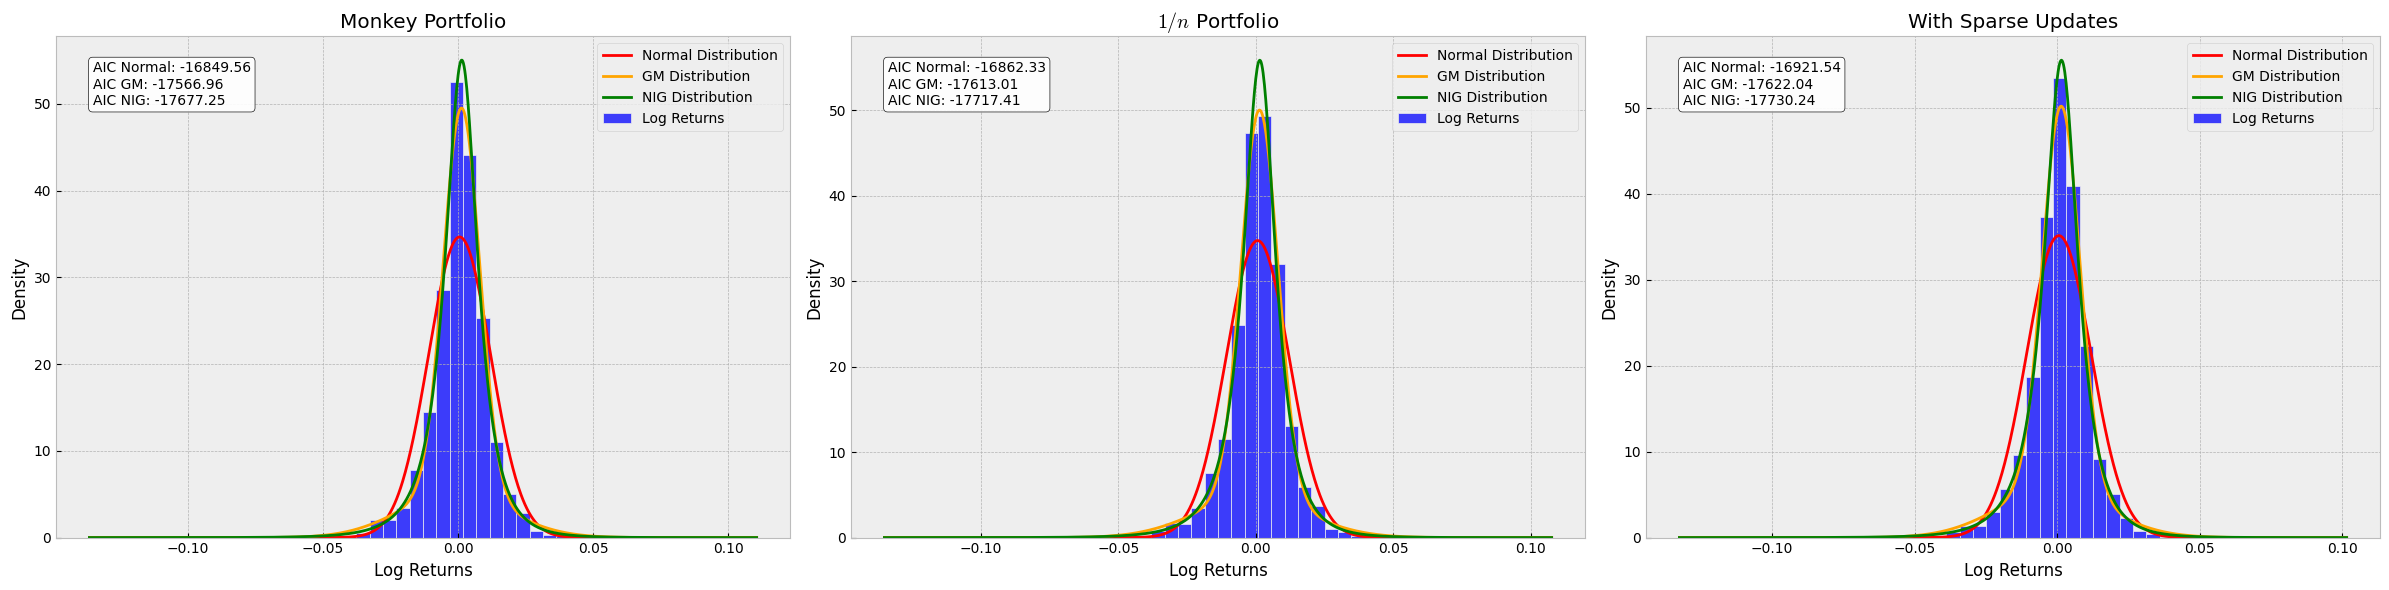

In [139]:
# Plot side by side
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

plt.sca(ax[0])
plot_portfolio_distribution(monkey_portfolio.aum, 'Monkey Portfolio')

plt.sca(ax[1])
plot_portfolio_distribution(portfolio.aum, '$1/n$ Portfolio')

plt.sca(ax[2])
plot_portfolio_distribution(sparse_update_portfolio.aum, 'With Sparse Updates')

plt.tight_layout()
plt.show()

## Portfolio analysis

### Case 1: Monkey Portfolio

In [149]:
process_portfolio(monkey_portfolio.aum, 'monkey_portfolio')

Expected Shortfall (CVaR) at the 95% confidence level for monkey_portfolio is: 0.0006200802310613273
The Expected Shortfall (CVaR) at the 95% confidence level is: 0.06%.
This means that on the worst {1 - confidence_level:.0%} of trading days, the average loss in the value of the portfolio is
expected to be 0.06% of the total portfolio value. It is a risk measure that gives
us an idea of the magnitude of a bad outcome in extreme scenarios. Therefore, in the context of risk management,
a financial analyst would interpret this as the average loss expected on the worst days beyond the VaR,
which can be considered when looking to mitigate extreme risks in portfolio planning.


### Case 2: $1/n$ Portfolio, monthly rebalancing

In [153]:
process_portfolio(portfolio.aum, 'portfolio')

Expected Shortfall (CVaR) at the 95% confidence level for portfolio is: 0.0006254672939108715
The Expected Shortfall (CVaR) at the 95% confidence level is: 0.06%.
This means that on the worst {1 - confidence_level:.0%} of trading days, the average loss in the value of the portfolio is
expected to be 0.06% of the total portfolio value. It is a risk measure that gives
us an idea of the magnitude of a bad outcome in extreme scenarios. Therefore, in the context of risk management,
a financial analyst would interpret this as the average loss expected on the worst days beyond the VaR,
which can be considered when looking to mitigate extreme risks in portfolio planning.


### Case 3: Sparse Updates Portfolio, monthly rebalancing

In [154]:
process_portfolio(sparse_update_portfolio.aum, 'sparse_update_portfolio')

Expected Shortfall (CVaR) at the 95% confidence level for sparse_update_portfolio is: 0.0005953111777300444
The Expected Shortfall (CVaR) at the 95% confidence level is: 0.06%.
This means that on the worst {1 - confidence_level:.0%} of trading days, the average loss in the value of the portfolio is
expected to be 0.06% of the total portfolio value. It is a risk measure that gives
us an idea of the magnitude of a bad outcome in extreme scenarios. Therefore, in the context of risk management,
a financial analyst would interpret this as the average loss expected on the worst days beyond the VaR,
which can be considered when looking to mitigate extreme risks in portfolio planning.
